## Initialize

In [84]:
import json
import os
import itertools
import math

import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap

In [7]:
# Check number of available GPUs
n_gpus = len(tf.config.list_physical_devices('GPU'))
assert n_gpus >= 1
print("Num GPUs Available:", n_gpus)

Num GPUs Available: 1


In [8]:
#Initialize Google Earth Engine
#just needed the 1st time
ee.Authenticate() 
ee.Initialize()

Enter verification code: 4/1AdQt8qiSKT8BqV81IEme5-zrqFRuBuAwuMXL1m1UM5m6Us8y_0qVxF-jxQI

Successfully saved authorization token.


## Define Globals

In [58]:
# Define classes
CLASSES = ['water',
           'vegetation_trees',
           'vegetation_grass',
           'turf',
           'impervious',
           'soil']

OLD_CLASSES = ['water_pools'] + CLASSES[1:]

# Change classes to include lakes
NEW_CLASSES = OLD_CLASSES + ['water_natural']
NEW_CLASSES[0] = 'water_pools'

# Get class lengths
N_CLASSES = len(NEW_CLASSES)

# Define the  bands
NBANDS = ['R', 
         'G', 
         'B', 
         'N', 
         'NDVI',
         'N_Entropy', 
         'N_Contrast', 
         'N_Gearys']

ALL_BANDS = NBANDS + ['R_Entropy',
                      'R_Contrast',
                      'R_Gearys',
                      'G_Entropy',
                      'G_Contrast',
                      'G_Gearys',
                      'B_Entropy',
                      'B_Contrast',
                      'B_Gearys']

In [10]:
# Select desired band set
BANDS = NBANDS

In [11]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Read in CSV data

In [86]:
def read_data(file, classes=None):
    
    '''
    Read data and reshape for CNN input
    '''
        
    # Read in data and shuffle
    data = pd.read_csv(file).to_numpy()
    np.random.shuffle(data)

    # Split into X and Y
    X, Y = data[:,:-1], data[:, -1].astype(int)
    
    # Print class counts if labels are specified
    if classes:
        _, counts = np.unique(Y, return_counts=True)
        print(file)
        df = pd.DataFrame({'class': classes, 'counts': counts})
        df['proportion'] = df['counts']/df['counts'].sum()
        print(df)
        print()

    # Convert Y to sparse dataset
    sparse_Y = np.zeros((Y.size, Y.max()+1))
    sparse_Y[np.arange(Y.size), Y] = 1

    # Reshape for 1x1 kernel convolutions
    conv_X = X.reshape((X.shape[0], 1, 1, X.shape[1]))
    conv_sparse_Y = sparse_Y.reshape((sparse_Y.shape[0], 1, 1, sparse_Y.shape[1]))
        
    return conv_X, conv_sparse_Y

In [87]:
# File names for the training and testing datasets
IMAGES_DIR = '../datasets/GoogleEarth'
TRAIN_FILE_PREFIX = 'training_waterlake_sep_cls_Nbands_0717'
TEST_FILE_PREFIX = 'testing_waterlake_sep_cls_Nbands_0717' 
FILE_EXT = '.csv'

CSV_TRAIN_FILE_PATH = os.path.join(IMAGES_DIR, (TRAIN_FILE_PREFIX + FILE_EXT))
CSV_TEST_FILE_PATH = os.path.join(IMAGES_DIR, (TEST_FILE_PREFIX + FILE_EXT))

In [88]:
# Set the seed for data shuffle
np.random.seed(123)

conv_train_X, conv_sparse_train_Y = read_data(CSV_TRAIN_FILE_PATH, NEW_CLASSES)
conv_test_X, conv_sparse_test_Y = read_data(CSV_TEST_FILE_PATH, NEW_CLASSES)

../datasets/GoogleEarth/training_waterlake_sep_cls_Nbands_0717.csv
              class  counts  proportion
0       water_pools    2336    0.009296
1  vegetation_trees   68413    0.272243
2  vegetation_grass   94741    0.377013
3              turf    3290    0.013092
4        impervious   71101    0.282940
5              soil    8995    0.035795
6     water_natural    2418    0.009622

../datasets/GoogleEarth/testing_waterlake_sep_cls_Nbands_0717.csv
              class  counts  proportion
0       water_pools     684    0.014931
1  vegetation_trees    4770    0.104123
2  vegetation_grass    8521    0.186003
3              turf    2635    0.057519
4        impervious    7006    0.152933
5              soil   21528    0.469931
6     water_natural     667    0.014560



In [89]:
conv_train_X.shape, conv_sparse_train_Y.shape

((251294, 1, 1, 8), (251294, 1, 1, 7))

In [90]:
conv_test_X.shape, conv_sparse_test_Y.shape

((45811, 1, 1, 8), (45811, 1, 1, 7))

## Evaluate model

### Custom F1 Metric

In [91]:
class MultiClassFBeta(keras.metrics.Metric):
    '''
    Define a custom F-beta metric class to optimize against
    during hyperparameter tuning. Class can perform F-beta calcutions
    for macro, weighted, and raw scores for any value of beta.
    
    Default is macro F1 score.
    '''
    
    def __init__(self,  n_class=N_CLASSES, name=None, beta=1, average='macro',
                 epsilon=1e-7, **kwargs):
        
        # If name is not provided, set default name
        if not name:
            name = f"{average}_f{beta}"

        # initializing an object of the Metric super class
        super(MultiClassFBeta, self).__init__(name=name, **kwargs)

        # initializing static variables 
        self.beta_squared = beta**2
        self.n_class = n_class
        self.average = average
        self.epsilon = epsilon

        # initializing state variables
        self.tp = self.add_weight(name='tp', 
                                  shape=(self.n_class,), 
                                  initializer='zeros')     # initializing true positives
        self.actual_positives = self.add_weight(name='ap', 
                                                shape=(self.n_class,), 
                                                initializer='zeros') # initializing actual positives
        self.predicted_positives = self.add_weight(name='pp',
                                                   shape=(self.n_class,), 
                                                   initializer='zeros') # initializing predicted positives

    
    def update_state(self, ytrue, ypred, sample_weight=None):

        '''
        Updates the metrics to preserve the running state
        '''

        # casting ytrue and ypred as float dtype
        ytrue = tf.cast(ytrue, tf.float32)
        ypred = tf.cast(ypred, tf.float32)

        # finding the maximum probability in ypred
        max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

        # making ypred one hot encoded such that the class with the maximum probability 
        # as encoded as 1 while others as 0
        ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)

        # Calculate TP, PP, AP
        TP = tf.reshape(tf.reduce_sum(ytrue*ypred, axis=0), [self.n_class])
        PP = tf.reshape(tf.reduce_sum(ypred, axis=0), [self.n_class])
        AP = tf.reshape(tf.reduce_sum(ytrue, axis=0), [self.n_class])

        self.tp.assign_add(TP) # updating true positives atrribute
        self.predicted_positives.assign_add(PP) # updating predicted positives atrribute
        self.actual_positives.assign_add(AP) # updating actual positives atrribute

    def result(self):
    
        '''
        Performs final metric computations and returns result
        '''

        self.precision = self.tp/(self.predicted_positives+self.epsilon) # calculates precision
        self.recall = self.tp/(self.actual_positives+self.epsilon) # calculates recall

        # calculating fbeta score
        self.fb = (1+self.beta_squared)*self.precision*self.recall / (self.beta_squared*self.precision + self.recall + self.epsilon)

        if self.average == 'weighted':
            return tf.reduce_sum(self.fb*self.actual_positives / tf.reduce_sum(self.actual_positives))

        elif self.average == 'raw':
            return self.fb

        return tf.reduce_mean(self.fb)

    def reset_state(self):
        
        '''
        Reset the tracked metrics (state)
        '''

        self.tp.assign(tf.zeros(self.n_class)) # resets true positives to zero
        self.predicted_positives.assign(tf.zeros(self.n_class)) # resets predicted positives to zero
        self.actual_positives.assign(tf.zeros(self.n_class)) # resets actual positives to zero

### Results

In [92]:
def get_classification_report(model, X, y_true, class_names, save_dir=None):
    
    # Get model predictions
    y_probs = model.predict(X)
    y_preds = y_probs.argmax(axis=-1)

    # If conv output, convert to 1d array
    if len(y_preds.shape) > 2:
        y_preds = y_preds.reshape(-1, 1)
        
    # If conv input, convert Y to 1d array
    if len(y_true.shape) > 2:
        n_classes = y_true.shape[-1]
        y_true = np.argmax(y_true.reshape(-1, n_classes), axis=1)
    
    # Get the classification report
    report = classification_report(y_true, y_preds, target_names=class_names)
    
    # Save the report if directory specified
    if save_dir:
        save_report = classification_report(y_true, y_preds, target_names=class_names, 
                                            output_dict=True)
        df = pd.DataFrame(save_report).transpose()
        df.to_csv(save_dir)
    
    return report, y_true, y_preds

In [93]:
def create_cmap(R, G, B, increasing_gradient=True, color_scale=256, mult=1):
    
    # Initialize colormap array
    color_vals = np.ones((color_scale, 4))
    
    # Calculate pixel value range for R,G,B
    R_start, R_end = R+(1-R)*(1-mult), R+(1-R)*(mult)
    G_start, G_end = G+(1-G)*(1-mult), G+(1-G)*(mult)
    B_start, B_end = B+(1-B)*(1-mult), B+(1-B)*(mult)
    
    bands = [(R_start, R_end), (G_start, G_end), (B_start, B_end)]

    # Create range of pixel values for R,G,B
    for i, color in enumerate(bands):   
        color_vals[:, i] = np.linspace(*color, color_scale)
        if increasing_gradient:
            color_vals[:, i] = color_vals[:, i][::-1]
    
    # Create colormap
    cmap = ListedColormap(color_vals)
    
    return cmap    

In [94]:
def plot_confusion_matrix(y_true, y_preds, save_cm_dir=None, **kwargs):
    
    # Plot the CM
    ConfusionMatrixDisplay.from_predictions(y_true, y_preds, **kwargs)
    
    # Save the CM if directory specified
    if save_cm_dir:
        plt.savefig(save_cm_dir)

In [95]:
# Load and evaluate model to test it's the same performance
save_dir = '../models/CNN_Nbands_sep_cls_wlake_model_1658106366'
best_nn_model = tf.keras.models.load_model(save_dir, custom_objects={'MultiClassFBeta': MultiClassFBeta})
best_nn_model.evaluate(conv_test_X, conv_sparse_test_Y)

1432/1432 [==============================] - 3s 2ms/step - loss: 0.3413 - macro_f1: 0.8922 - accuracy: 0.9120


[0.3412821590900421, 0.8921681046485901, 0.911986231803894]

In [96]:
# Get the classification report and save it
report_path = os.path.join(save_dir, 'classification_report.csv')
report, y_true, y_preds = get_classification_report(best_nn_model, conv_test_X, conv_sparse_test_Y,
                                                   NEW_CLASSES, save_dir=report_path)

print(report)

                  precision    recall  f1-score   support

     water_pools       0.97      1.00      0.99       684
vegetation_trees       0.81      0.91      0.86      4770
vegetation_grass       0.85      0.93      0.89      8521
            turf       1.00      0.84      0.91      2635
      impervious       0.84      0.95      0.89      7006
            soil       0.99      0.91      0.94     21528
   water_natural       0.99      0.63      0.77       667

        accuracy                           0.91     45811
       macro avg       0.92      0.88      0.89     45811
    weighted avg       0.92      0.91      0.91     45811



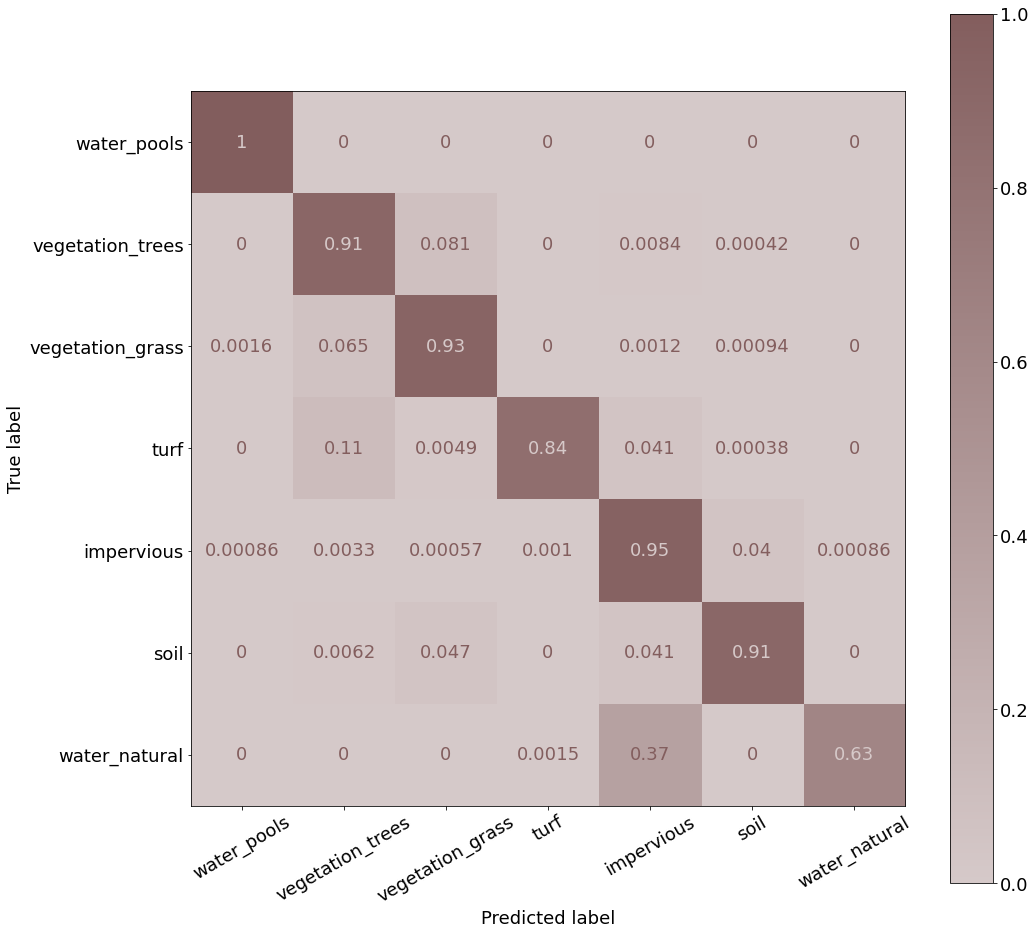

In [97]:
plt.rcParams.update({'text.color': "black",
                     'font.size' : 18,
                     })

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)

# Create brown colormap
brown_R = 90/256
brown_G = brown_B = 40/256
mult = 0.75

brown_cmp = create_cmap(brown_R, brown_G, brown_B, mult=mult)

# Plot the confusion matrix and save the figure
cm_path = os.path.join(save_dir, 'confusion_matrix.png')

plot_confusion_matrix(y_true, y_preds, save_cm_dir=cm_path,
                      display_labels=NEW_CLASSES, ax=ax, normalize='true', 
                      cmap=brown_cmp, xticks_rotation=30)
plt.show()

## Visualize model predictions

### Build Training Image

In [98]:
def apply_3bands(image, band):
    i_8_bit = image.select(band).toUint8()
    square = ee.Kernel.square(**{'radius': 4})
    entropy = i_8_bit.entropy(square)
    glcm = i_8_bit.glcmTexture(**{'size': 4})
    contrast = glcm.select(str(band)+'_contrast')
    
    # Create a list of weights for a 9x9 kernel.
    list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    # The center of the kernel is zero.
    centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
    # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
    lists = [list, list, list, list, centerList, list, list, list, list]
    # Create the kernel from the weights.
    # Non-zero weights represent the spatial neighborhood.
    kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)
    neighs = i_8_bit.neighborhoodToBands(kernel)
    gearys = i_8_bit.subtract(neighs).pow(2).reduce(ee.Reducer.sum()).divide(math.pow(9, 2))
    image = image.addBands(entropy.rename(str(band)+'_Entropy')).addBands(contrast.rename(str(band)+'_Contrast')).addBands(gearys.rename(str(band)+'_Gearys'))   
    return image

def add_neighborhood_bands(image):
    bands = ['R', 'G', 'B', 'N']
    for band in bands:
        image = apply_3bands(image, band)
    return image
    
def add_NDVI(image):
    image = image.addBands(image.normalizedDifference(['N','R']).rename('NDVI'))
    return image
     

In [99]:
def get_images(param_dict):
    source_image_collection = param_dict['source_image_collection']
    years = param_dict['years']
    counties = param_dict['counties']

    image_names = []
    images = []

    combos = list(itertools.product(years, counties.keys()))
    for i in combos:
        year = str(i[0])
        county = i[1]

        image_name = str(i[0])+'_'+i[1]
        image_names.append(image_name)

        image = ee.ImageCollection(source_image_collection)\
                                .filterDate(f'{year}-01-01', f'{year}-12-31')\
                                .select(['R','G','B','N'])\
                                .median().clip(counties[county])
        images.append(image)
        images_with_3band = list(map(add_neighborhood_bands, images))
        images_with_NDVI = list(map(add_NDVI, images_with_3band))
    return dict(zip(image_names, images_with_NDVI))

In [100]:
# Loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

# Filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))

# Create training image
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'la_county': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_la_county']

# Add training image as layer
Map.addLayer(TRAINING_IMAGE, {}, 'TRAINING_IMAGE')

### Classify Training Image

In [108]:
def get_TF_classified_image(image, bands, tf_model, classes, name='classification'):
    
    '''
    Use a TF model hosted on Google AI Platform to classify an EE image.
    '''
    
    # Select bands from training image for classification
    selected_image = image.select(bands)

    # Get the predictions
    predictions = tf_model.predictImage(selected_image.float().toArray())
    probabilities = predictions.arrayFlatten([classes])
    classified_image = predictions.arrayArgmax().arrayGet([0]).rename(name)
    
    return classified_image, predictions, probabilities

In [109]:
def get_ensembled_classified_image(image, bands, model_dicts):
    
    """
    Get the ensembled classified image by getting the max prediction probability
    for each pixel across all models. 
    
    Each dict in model_dicts should contain the following keys for a particular model:
        'model': the ee.Model object
        'classes': the classes that the model will try to predict
        'image_name': the name of the classified image from the model 
    """
    
    output_images = []
    combined_probs = None
    
    for model_dict in model_dicts:
        # Unpack the model metadata
        model = model_dict['model']
        classes = model_dict['classes']
        image_name = model_dict['image_name']
        
        # Predict on classified image
        temp_image, temp_preds, temp_probs = get_TF_classified_image(image, bands, model, classes, name=image_name)
        
        # If no combined_probs set, set it to temp_probs
        if combined_probs is None:
            combined_probs = temp_probs
        
        # Check if classes are not the same, then add missing bands 
        cur_prob_bands = set(combined_probs.bandNames().getInfo())
        add_cur_bands = list(cur_prob_bands - set(classes))
        add_new_bands = list(set(classes) - cur_prob_bands)
        
        if add_cur_bands:
            temp_probs = temp_probs.addBands(combined_probs, add_cur_bands)
        if add_new_bands:
            combined_probs = combined_probs.addBands(temp_probs, add_new_bands)
        
        # Get the max probs across the two images
        combined_probs = combined_probs.max(temp_probs)
        output_images.append(temp_image)
    
    # Get the final combined classification image based on maximum probabilities
    classified_image = combined_probs.toArray().arrayArgmax().arrayGet([0]).rename('combined_classification')
    output_images.append(classified_image)
    
    return output_images

In [110]:
# Point to the TF model(s) to be used for inference
PROJECT = 'w210-351617'
VERSION_NAME = 'v0'
OLD_MODEL_NAME = 'CNN_Nbands_model'
NEW_MODEL_NAME = 'CNN_Nbands_sep_cls_wlake_model'

input_dim = [12,12]

# Point to the old model hosted on AI Platform.
old_tf_model = ee.Model.fromAiPlatformPredictor(
    projectName=PROJECT,
    modelName=OLD_MODEL_NAME,
    version=VERSION_NAME,
    # Can be anything, but don't make it too big.
    inputTileSize=input_dim,
    # Note the names here need to match what was specified in the
    # output dictionary passed to the EEifier originally
    outputBands={'output': {
        'type': ee.PixelType.float(),
        'dimensions': 1
      }
    },
)

# Point to the old model hosted on AI Platform.
new_tf_model = ee.Model.fromAiPlatformPredictor(
    projectName=PROJECT,
    modelName=NEW_MODEL_NAME,
    version=VERSION_NAME,
    # Can be anything, but don't make it too big.
    inputTileSize=input_dim,
    # Note the names here need to match what was specified in the
    # output dictionary passed to the EEifier originally
    outputBands={'output': {
        'type': ee.PixelType.float(),
        'dimensions': 1
      }
    },
)

In [129]:
model_dicts = [
    {'model': old_tf_model, 'classes': OLD_CLASSES, 'image_name':'old_classification'},
    {'model': new_tf_model, 'classes': NEW_CLASSES, 'image_name':'new_classification'},
]

# Classify the training image per model + ensembled
classified_images = get_ensembled_classified_image(TRAINING_IMAGE, BANDS, model_dicts)

# Remap the combined image so lakes are classified as pools together
fromList = [0, 1, 2, 3, 4, 5, 6]
toList = [0, 1, 2, 3, 4, 5, 0]

classified_images[-1] = classified_images[-1].remap(fromList, toList)
classified_images[-1].getInfo()

In [132]:
old_legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']
new_legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911', '#191970']

colors_list = [old_legend_colors, new_legend_colors, old_legend_colors]

for colors, image in zip(colors_list, classified_images):
    layer_name = image.getInfo()['bands'][0]['id']
    Map.addLayer(image, {'min': 0, 'max': len(colors)-1, 'palette': colors}, layer_name)

In [133]:
Map

Map(bottom=52633.0, center=[34.05948596794815, -118.47518920898439], controls=(WidgetControl(options=['positio…